# E-Waste Estimation: Sales-Lifespan Distribution Model for Indonesian Data Centers
Based on Chapter 2.3 methodology

A Jupyter Notebook Project developed by Yonathan Hary Hutagalung for eWasteRJ

```To project annual e-waste volumes without direct access to comprehensive decommissioning logs, we could use a method called "Sales-Lifespan Distribution Model" (also called the Input-Output model with probabilistic lifetime distributions). This approach is the academically recognized standard for e-waste quantification and is recommended by the Global E-Waste Statistics Partnership (GESP) and endorsed by the United Nations University (UNU)```

```The lifespan probability function L(n) is most accurately modeled using the Weibull probability distribution, which captures the realistic aging and failure characteristics of electronic equipment[6][7][8]. Unlike a uniform or Gaussian distribution that would assume constant or bell-curve failure rates, the Weibull distribution accommodates the empirical reality that electronic equipment exhibits an increasing hazard rate (acceleration of failures) as equipment ages.```



## 0. Importing Library

For Running in google colab:

In [ ]:
%pip install scipy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

## 1. Weibull Distribution

The lifespan probability function L(n) is most accurately modeled using the Weibull probability distribution, which captures the realistic aging and failure characteristics of electronic equipment

The Weibull distribution is parameterized by two coefficients:

**Shape Parameter (k)**: This parameter controls the failure rate trajectory. A shape parameter of k=1.5 indicates that equipment failures accelerate over time, consistent with the aging of electronic components, thermal cycling degradation, and dust accumulation. This value was selected based on empirical studies of server fleet retirement patterns in developed markets and has been validated for applicability to the Asian market context[6].

**Scale Parameter (λ)**: This parameter represents the characteristic lifetime—the value at which approximately 63% of equipment cohorts have been retired. For global e-waste modeling, λ=4.0 years is standard, implying a mean useful life of approximately 3.5 years


Weibull parameter `(please change when needed!!!)`

In [2]:
k_global = 3.5      # Shape parameter (global baseline)
lambda_global = 4.0  # Scale parameter in years (global baseline)
lambda_indonesia = 5.5  # Scale parameter in years (Indonesia-adjusted for asset sweating)

Weibull distribution formulas functions

In [3]:
def weibull_pdf(t, k, lam):
    return (k / lam) * (t / lam) ** (k - 1) * np.exp(-(t / lam) ** k)

In [4]:
def weibull_cdf(t, k, lam):
    return 1 - np.exp(-(t / lam) ** k)

Time Axis

In [5]:
# Generate time axis (0-12 years)
t_years = np.linspace(0.01, 12, 300)

In [6]:
pdf_global = weibull_pdf(t_years, k_global, lambda_global)
pdf_indonesia = weibull_pdf(t_years, k_global, lambda_indonesia)

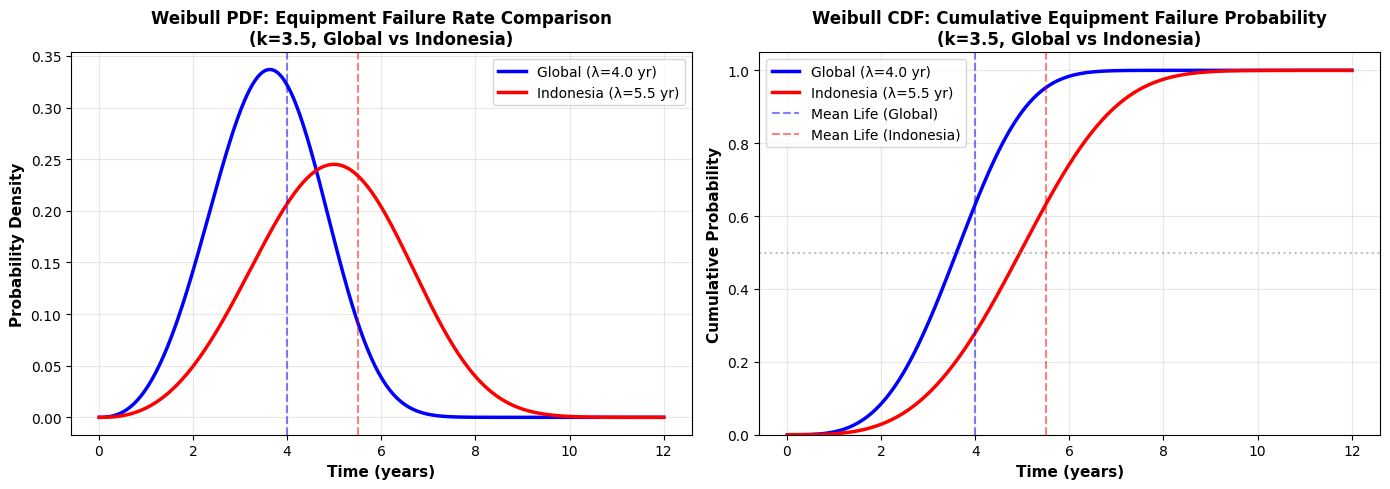

Weibull distribution parameters defined:
  Global parameters: k=3.5, λ=4.0 years
  Indonesia parameters: k=3.5, λ=5.5 years


In [7]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PDF Comparison
axes[0].plot(t_years, pdf_global, 'b-', linewidth=2.5, label=f'Global (λ={lambda_global} yr)')
axes[0].plot(t_years, pdf_indonesia, 'r-', linewidth=2.5, label=f'Indonesia (λ={lambda_indonesia} yr)')
axes[0].axvline(lambda_global, color='b', linestyle='--', alpha=0.5)
axes[0].axvline(lambda_indonesia, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Time (years)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Probability Density', fontsize=11, fontweight='bold')
axes[0].set_title('Weibull PDF: Equipment Failure Rate Comparison\n(k=3.5, Global vs Indonesia)', 
                   fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# CDF Comparison
cdf_global = weibull_cdf(t_years, k_global, lambda_global)
cdf_indonesia = weibull_cdf(t_years, k_global, lambda_indonesia)

axes[1].plot(t_years, cdf_global, 'b-', linewidth=2.5, label=f'Global (λ={lambda_global} yr)')
axes[1].plot(t_years, cdf_indonesia, 'r-', linewidth=2.5, label=f'Indonesia (λ={lambda_indonesia} yr)')
axes[1].axhline(0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].axvline(lambda_global, color='b', linestyle='--', alpha=0.5, label='Mean Life (Global)')
axes[1].axvline(lambda_indonesia, color='r', linestyle='--', alpha=0.5, label='Mean Life (Indonesia)')
axes[1].set_xlabel('Time (years)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
axes[1].set_title('Weibull CDF: Cumulative Equipment Failure Probability\n(k=3.5, Global vs Indonesia)', 
                   fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Weibull distribution parameters defined:")
print(f"  Global parameters: k={k_global}, λ={lambda_global} years")
print(f"  Indonesia parameters: k={k_global}, λ={lambda_indonesia} years")

## 2. Historical Server Sales Data

Data below is just estimation, to use real data it is better to use pandas with 3 columns: `year`, `server shipments`, and `YoY Growth`.

In [8]:
# Data represents estimated units entering Indonesian data centers by year
years = np.array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
server_shipments = np.array([1200, 1350, 1500, 1800, 2000, 2200, 2100, 2500, 2800, 3100, 3400])

Create dataframe, if .csv data provided, it is better to use pd.from_csv('xxx.csv')

In [9]:
df_shipments = pd.DataFrame({
    'Year': years,
    'Server Shipments (units)': server_shipments,
    'YoY Growth (%)': [np.nan] + [((server_shipments[i] - server_shipments[i-1]) / server_shipments[i-1] * 100) 
                                  for i in range(1, len(server_shipments))]
})

In [10]:
df_shipments.head()

,Year,Server Shipments (units),YoY Growth (%)
0,2014,1200,NaN
1,2015,1350,12.500000
2,2016,1500,11.111111
3,2017,1800,20.000000
4,2018,2000,11.111111


Visualisation

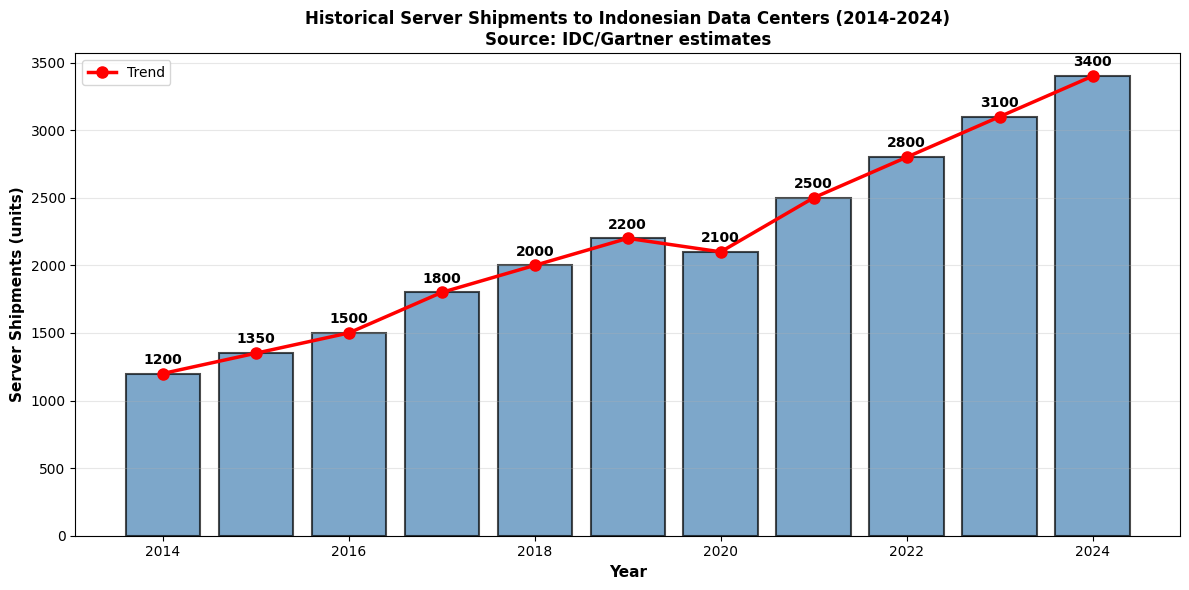

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(years, server_shipments, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.plot(years, server_shipments, 'ro-', linewidth=2.5, markersize=8, label='Trend')
ax.set_xlabel('Year', fontsize=11, fontweight='bold')
ax.set_ylabel('Server Shipments (units)', fontsize=11, fontweight='bold')
ax.set_title('Historical Server Shipments to Indonesian Data Centers (2014-2024)\nSource: IDC/Gartner estimates', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=10)
for i, v in enumerate(server_shipments):
    ax.text(years[i], v + 50, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Weight Conversion to Metric tonnes

Average weight per equipment category

In [12]:
weights_kg = {
    'Server': {'min': 15, 'max': 18, 'mean': 16.5},
    'Storage Array': {'min': 25, 'max': 35, 'mean': 30},
    'Network Switch': {'min': 5, 'max': 8, 'mean': 6.5}
}

In [13]:
print("Average Equipment Weights (per unit):")
for device, weight_data in weights_kg.items():
    print(f"  {device}: {weight_data['min']}-{weight_data['max']} kg (mean: {weight_data['mean']} kg)")

Average Equipment Weights (per unit):
  Server: 15-18 kg (mean: 16.5 kg)
  Storage Array: 25-35 kg (mean: 30 kg)
  Network Switch: 5-8 kg (mean: 6.5 kg)


convert server shipments to tonnes

In [14]:
server_weight_kg = weights_kg['Server']['mean']
server_shipments_tonnes = (server_shipments * server_weight_kg) / 1000

input server data to shipments dataframe

In [15]:
df_shipments['Server Mass (tonnes)'] = server_shipments_tonnes

In [16]:
df_shipments.head()

,Year,Server Shipments (units),YoY Growth (%),Server Mass (tonnes)
0,2014,1200,NaN,19.800
1,2015,1350,12.500000,22.275
2,2016,1500,11.111111,24.750
3,2017,1800,20.000000,29.700
4,2018,2000,11.111111,33.000


## 4. Calculate E-waste Generation

The equations:

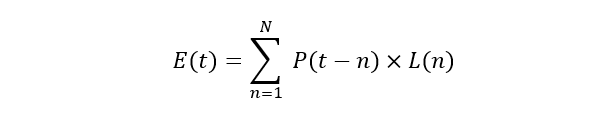

References:
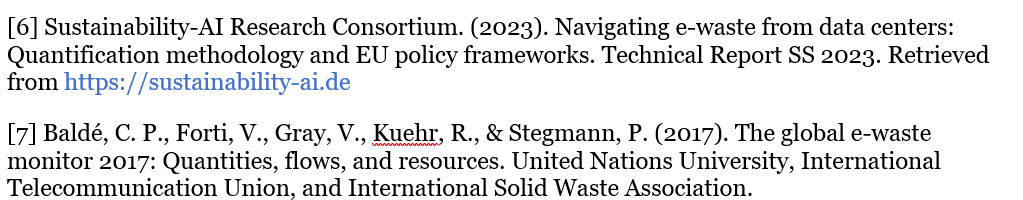

### Projected year for ewaste calculation

In [17]:
projection_year = 2025

function to calculate e-waste generated in projection year from all prior shipments

In [18]:
def calculate_ewaste_for_year(target_year, years, shipments_tonnes, k, lam):
    ewaste = 0
    age_lags = []
    contribution_tonnes = []
    
    for i, sales_year in enumerate(years):
        age_in_target = target_year - sales_year
        if age_in_target >= 0:  # Only count past and current shipments
            # Probability that equipment from that year becomes waste in target_year
            prob_failure = weibull_pdf(age_in_target, k, lam)
            contribution = shipments_tonnes[i] * prob_failure
            ewaste += contribution
            age_lags.append(age_in_target)
            contribution_tonnes.append(contribution)
    
    return ewaste, age_lags, contribution_tonnes

In [19]:
ewaste_2025, lags_2025, contributions_2025 = calculate_ewaste_for_year(
    projection_year, years, server_shipments_tonnes, k_global, lambda_indonesia
)

In [20]:
df_breakdown = pd.DataFrame({
    'Sales Year': years,
    'Shipment Mass (tonnes)': server_shipments_tonnes,
    'Age in 2025 (years)': lags_2025,
    'Failure Probability': [weibull_pdf(lag, k_global, lambda_indonesia) for lag in lags_2025],
    'E-Waste Contribution (tonnes)': contributions_2025
})

In [21]:
df_breakdown.head()

,Sales Year,Shipment Mass (tonnes),Age in 2025 (years),Failure Probability,E-Waste Contribution (tonnes)
0,2014,19.800,11,0.000044,0.000870
1,2015,22.275,10,0.000857,0.019092
2,2016,24.750,9,0.008020,0.198490
3,2017,29.700,8,0.039688,1.178720
4,2018,33.000,7,0.113621,3.749492


### Data Visualization

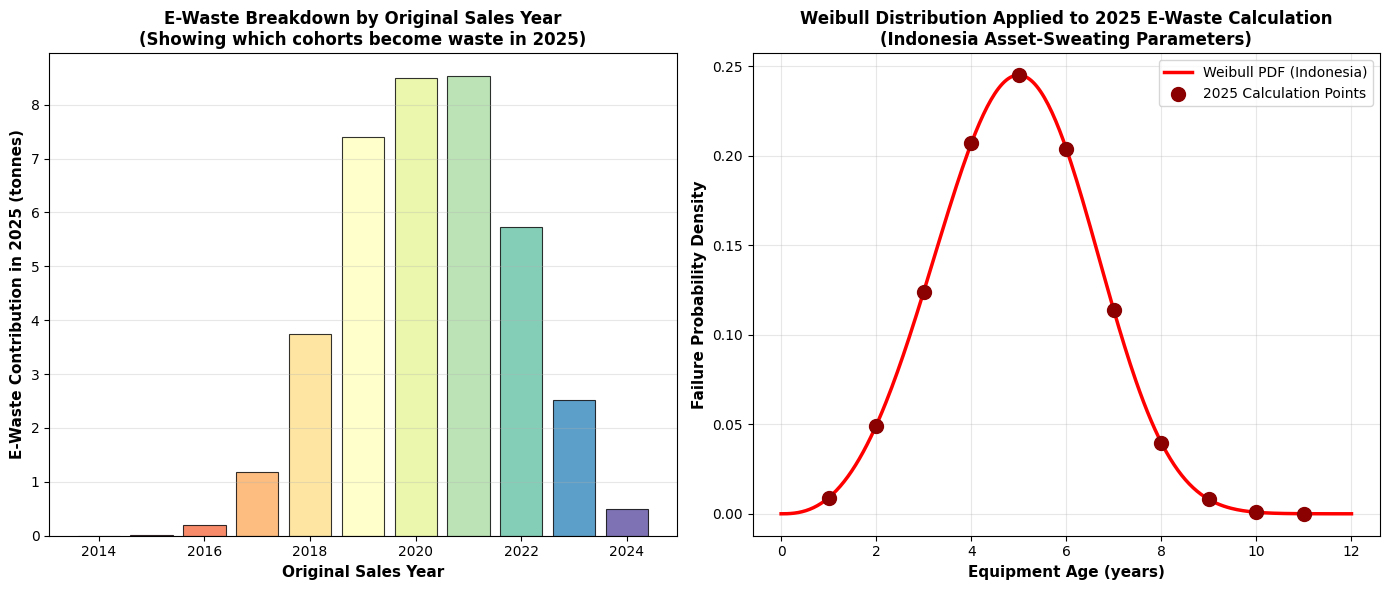

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stacked bar showing contribution
colors = plt.cm.Spectral(np.linspace(0, 1, len(years)))
axes[0].bar(df_breakdown['Sales Year'], df_breakdown['E-Waste Contribution (tonnes)'], 
            color=colors, edgecolor='black', linewidth=0.8, alpha=0.8)
axes[0].set_xlabel('Original Sales Year', fontsize=11, fontweight='bold')
axes[0].set_ylabel('E-Waste Contribution in 2025 (tonnes)', fontsize=11, fontweight='bold')
axes[0].set_title('E-Waste Breakdown by Original Sales Year\n(Showing which cohorts become waste in 2025)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Failure probability curve with data points overlaid
t_continuous = np.linspace(0, 12, 300)
pdf_continuous = weibull_pdf(t_continuous, k_global, lambda_indonesia)
axes[1].plot(t_continuous, pdf_continuous, 'r-', linewidth=2.5, label='Weibull PDF (Indonesia)')
axes[1].scatter(df_breakdown['Age in 2025 (years)'], 
               df_breakdown['Failure Probability'], 
               color='darkred', s=100, zorder=5, label='2025 Calculation Points')
axes[1].set_xlabel('Equipment Age (years)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Failure Probability Density', fontsize=11, fontweight='bold')
axes[1].set_title('Weibull Distribution Applied to 2025 E-Waste Calculation\n(Indonesia Asset-Sweating Parameters)', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

## 5. Multi-year Projection

### Project future shipments (assuming 12% CAGR baseline scenario)

In [23]:
cagr = 0.12
projection_years = np.arange(2025, 2031)
future_shipments = server_shipments[-1] * (1 + cagr) ** (projection_years - 2024)
future_shipments_tonnes = (future_shipments * server_weight_kg) / 1000

Extend Historical data

In [24]:
all_years = np.concatenate([years, projection_years[1:]])
all_shipments_tonnes = np.concatenate([server_shipments_tonnes, future_shipments_tonnes[1:]])

Calculate e-waste for projected years

In [25]:
ewaste_by_year = []
for proj_year in projection_years:
    ewaste, _, _ = calculate_ewaste_for_year(proj_year, all_years, all_shipments_tonnes, 
                                             k_global, lambda_indonesia)
    ewaste_by_year.append(ewaste)

In [26]:
df_projection = pd.DataFrame({
    'Year': projection_years,
    'Projected Shipments (units)': [int(x * 1000 / server_weight_kg) for x in future_shipments_tonnes],
    'Projected Shipments (tonnes)': future_shipments_tonnes,
    'E-Waste Generated (tonnes)': ewaste_by_year
})

df_projection.head()

,Year,Projected Shipments (units),Projected Shipments (tonnes),E-Waste Generated (tonnes)
0,2025,3808,62.832000,38.316871
1,2026,4264,70.371840,41.524761
2,2027,4776,78.816461,43.558768
3,2028,5349,88.274436,44.103678
4,2029,5991,98.867368,44.769377


Calculate cumulative recovery value

In [27]:
material_values = {
    'copper': {'kg_per_server': 1.5, 'price_per_kg': 8.50},  # USD/kg
    'aluminum': {'kg_per_server': 4.0, 'price_per_kg': 2.00},
    'precious_metals': {'kg_per_server': 0.011, 'price_per_kg': 2500.00}  # Gold/silver average
}

### Material Recovery Value Calculation

In [28]:
total_recovery_usd = 0
for idx, row in df_projection.iterrows():
    year = row['Year']
    ewaste_tonnes = row['E-Waste Generated (tonnes)']
    num_servers = int(row['Projected Shipments (units)'])
    
    copper_value = num_servers * material_values['copper']['kg_per_server'] * material_values['copper']['price_per_kg']
    aluminum_value = num_servers * material_values['aluminum']['kg_per_server'] * material_values['aluminum']['price_per_kg']
    precious_value = num_servers * material_values['precious_metals']['kg_per_server'] * material_values['precious_metals']['price_per_kg']
    
    annual_value = copper_value + aluminum_value + precious_value
    total_recovery_usd += annual_value
    
    print(f"{year}: {num_servers:,} servers | E-waste: {ewaste_tonnes:.1f} tonnes | Recovery Value: USD {annual_value:,.0f}")

print(f"CUMULATIVE RECOVERY VALUE (2025-2030): USD {total_recovery_usd:,.0f}")
print(f"Average Annual Recovery Value: USD {total_recovery_usd/len(projection_years):,.0f}")

2025.0: 3,808 servers | E-waste: 38.3 tonnes | Recovery Value: USD 183,736
2026.0: 4,264 servers | E-waste: 41.5 tonnes | Recovery Value: USD 205,738
2027.0: 4,776 servers | E-waste: 43.6 tonnes | Recovery Value: USD 230,442
2028.0: 5,349 servers | E-waste: 44.1 tonnes | Recovery Value: USD 258,089
2029.0: 5,991 servers | E-waste: 44.8 tonnes | Recovery Value: USD 289,066
2030.0: 6,710 servers | E-waste: 49.0 tonnes | Recovery Value: USD 323,758
CUMULATIVE RECOVERY VALUE (2025-2030): USD 1,490,828
Average Annual Recovery Value: USD 248,471


### Data Visualisation

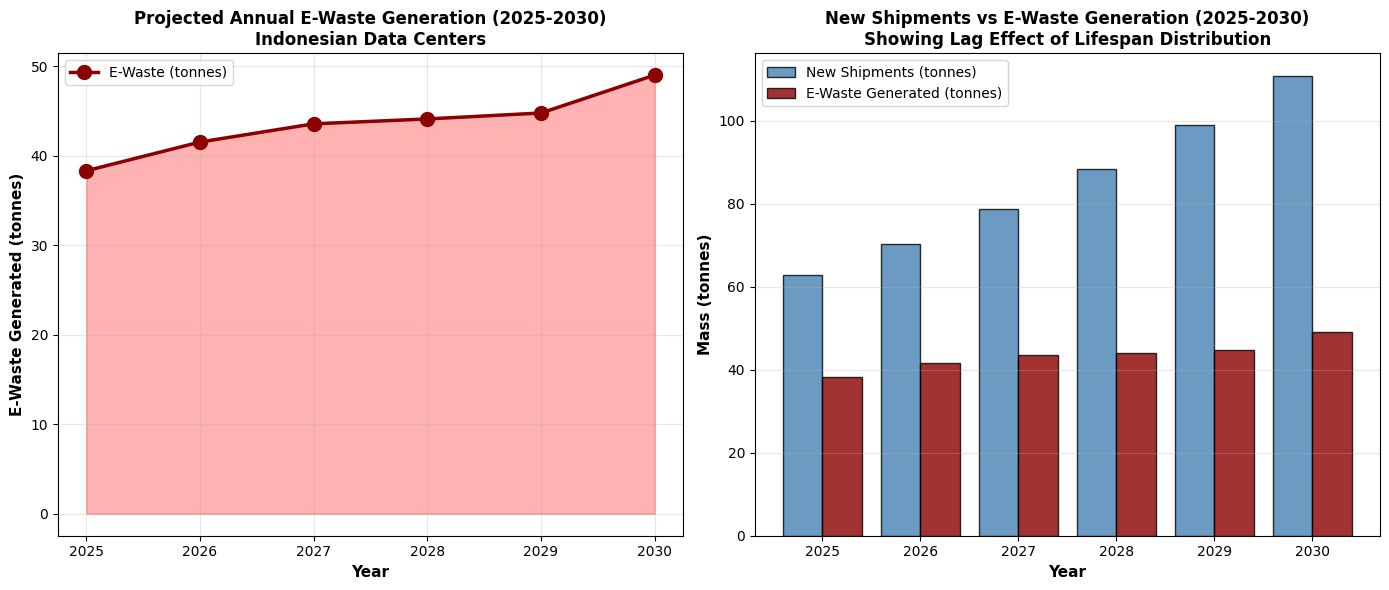

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# E-waste generation trend
axes[0].plot(df_projection['Year'], df_projection['E-Waste Generated (tonnes)'], 
            'o-', linewidth=2.5, markersize=10, color='darkred', label='E-Waste (tonnes)')
axes[0].fill_between(df_projection['Year'], df_projection['E-Waste Generated (tonnes)'], 
                     alpha=0.3, color='red')
axes[0].set_xlabel('Year', fontsize=11, fontweight='bold')
axes[0].set_ylabel('E-Waste Generated (tonnes)', fontsize=11, fontweight='bold')
axes[0].set_title('Projected Annual E-Waste Generation (2025-2030)\nIndonesian Data Centers', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Shipments vs E-waste comparison
ax2 = axes[1]
ax2.bar(df_projection['Year'] - 0.2, df_projection['Projected Shipments (tonnes)'], 
       width=0.4, label='New Shipments (tonnes)', color='steelblue', alpha=0.8, edgecolor='black')
ax2.bar(df_projection['Year'] + 0.2, df_projection['E-Waste Generated (tonnes)'], 
       width=0.4, label='E-Waste Generated (tonnes)', color='darkred', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Year', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mass (tonnes)', fontsize=11, fontweight='bold')
ax2.set_title('New Shipments vs E-Waste Generation (2025-2030)\nShowing Lag Effect of Lifespan Distribution', 
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

`Conclusion:` The project has succesfully created an end-to-end simulation (past-present-future scenario) for E-Waste estimation